In [1]:
include("../src/ising2d.jl")
import CairoMakie as cm
import LsqFit as lsq
using JLD2
using ProgressMeter
import StatsBase as sb
import Distributions as dist
import MultivariateStats as mvs
import Clustering as cl

## generate data


In [2]:
N_Sample = 1_000
grid_sizes = [10, 32]
temps = collect(1.0:0.005:4.0)

grids = []
mags = []
sus = []
for L in grid_sizes
    grids_L = Array{Array{Int,1},1}(undef, length(temps) * N_Sample)
    mags_ = Array{Float64,1}(undef, length(temps))
    sus_ = Array{Float64,1}(undef, length(temps))
    @showprogress Threads.@threads for (i, T) in collect(enumerate(temps))
        lookup_table = create_lookup_table(T)
        grid = create_equilibrated_grid(grid_size=L, lookup_table=lookup_table, T=T, initial_up_prob=0.5)
        energies_, magnetisations_, grids_ = sample_grid(grid, lookup_table, T=T, N=N_Sample,N_Subsweep=100*L^2)
        for j in 1:N_Sample
            grids_L[(i-1)*N_Sample+j] = grids_[j]
        end

        mags_[i] = mean(abs.(magnetisations_))
        sus_[i] = std(abs.(magnetisations_))^2 / T
    end
    push!(grids, grids_L)
    push!(mags, mags_)
    push!(sus, sus_)
end

expanded_temps = repeat(temps, inner=N_Sample)
length(temps)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


601

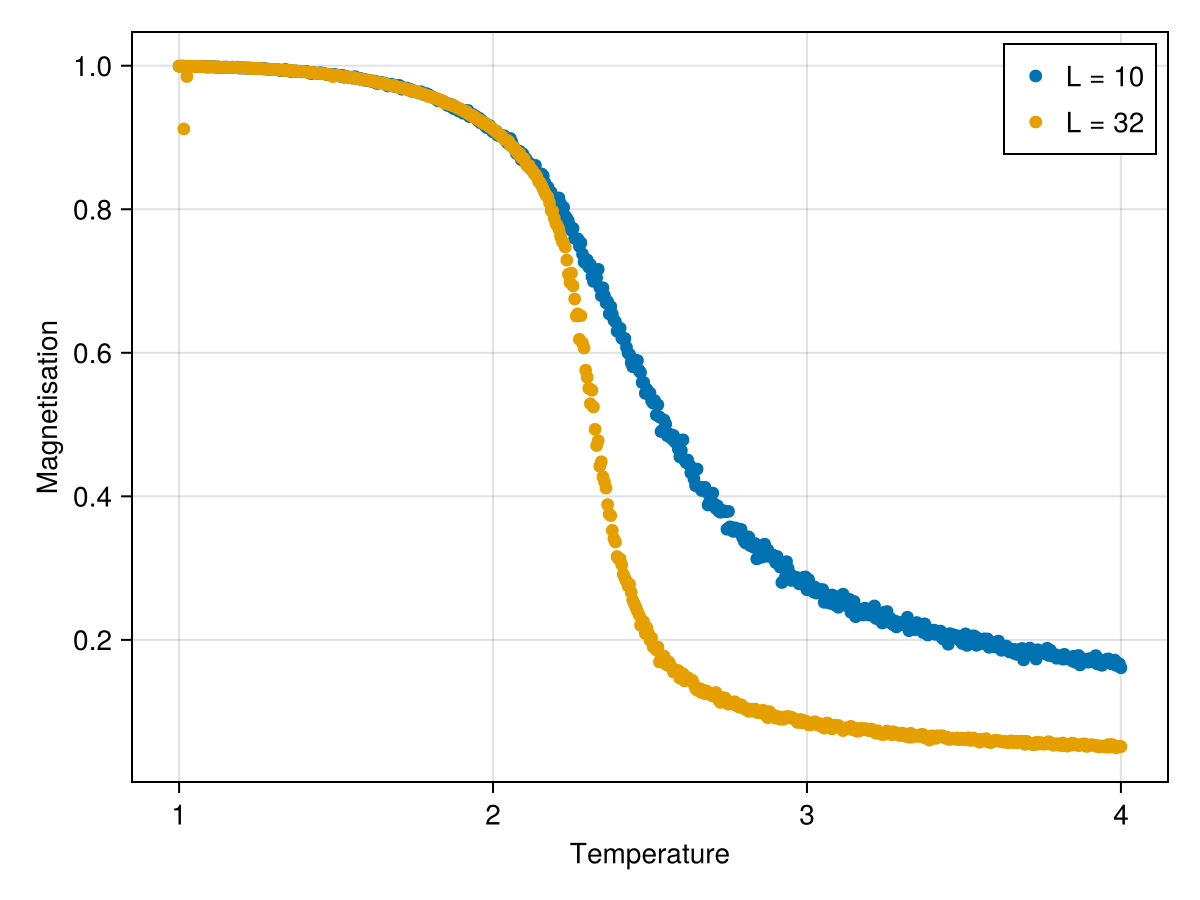

In [3]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Temperature", ylabel="Magnetisation")
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, mags[i], label="L = $L")
end

cm.axislegend(ax, position=:rt)

fig

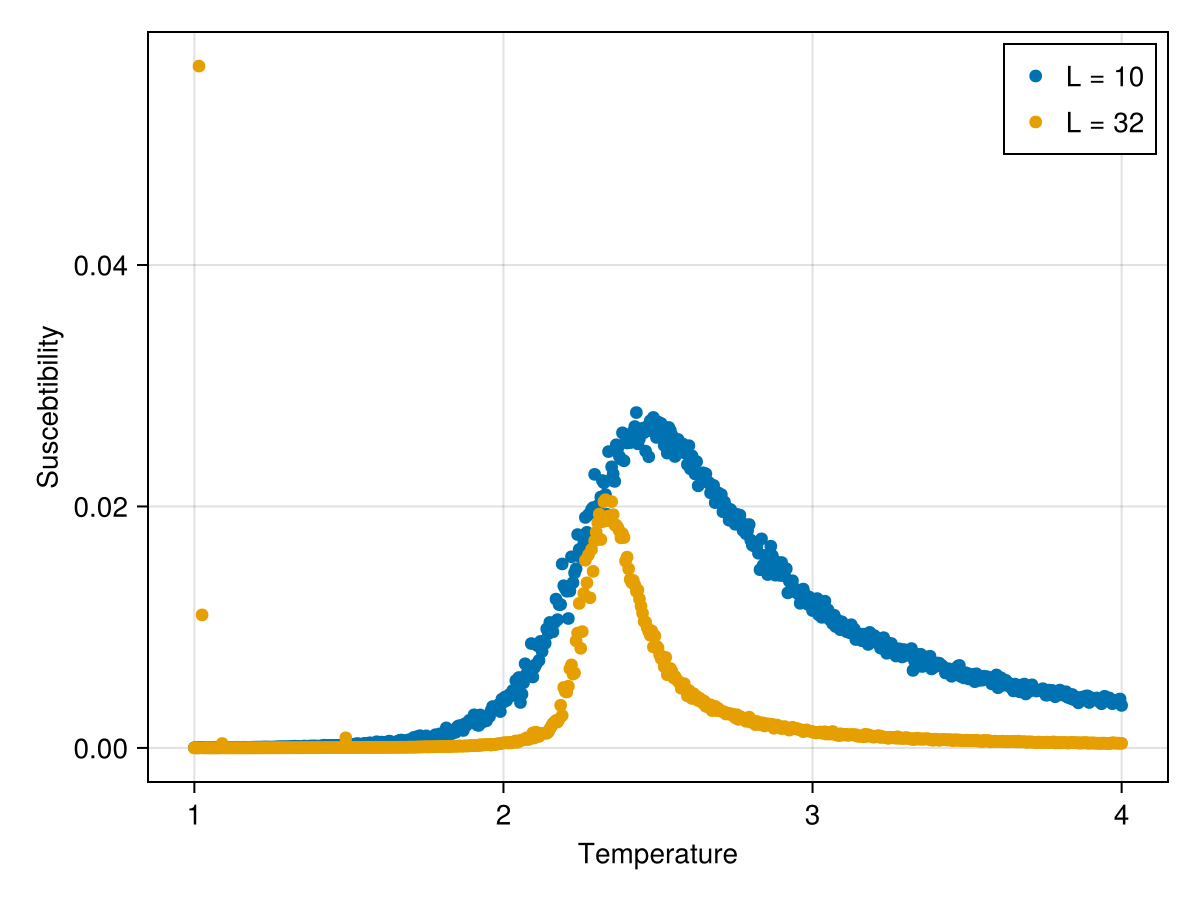

In [4]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Temperature", ylabel="Suscebtibility")
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, sus[i], label="L = $L")
end

cm.axislegend(ax, position=:rt)

fig

In [5]:
hcat(grids[1]...)

100×601000 Matrix{Int64}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …   1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
  ⋮                   ⋮              ⋱                   ⋮              
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 

## principal component analysis


In [6]:
M = []
for g in grids
    push!(M, sb.fit(mvs.PCA, hcat(g...), maxoutdim=2))
end

M[1]

PCA(indim = 100, outdim = 2, principalratio = 0.5211062300059967)

Pattern matrix (unstandardized loadings):
──────────────────────────
          PC1          PC2
──────────────────────────
1    0.683655  -0.154983
2    0.69451   -0.05202
3    0.727809  -0.0750211
4    0.727902   0.0373534
5    0.698256  -0.00286312
6    0.710592  -0.139499
7    0.697366  -0.195336
8    0.682882  -0.191003
9    0.721826  -0.263946
10   0.696378  -0.17031
11   0.688118  -0.0228236
12   0.712479   0.0769293
13   0.730485   0.0770716
14   0.703735   0.117961
15   0.696653   0.0395163
16   0.737449  -0.028477
17   0.725497  -0.117637
18   0.728846  -0.220109
19   0.704003  -0.18347
20   0.689145  -0.171796
21   0.691763   0.127305
22   0.712615   0.24626
23   0.708523   0.210796
24   0.678482   0.27038
25   0.680838   0.169405
26   0.701359   0.0274629
27   0.678725   0.0167236
28   0.661481  -0.0733421
29   0.666404  -0.0874915
30   0.667789   0.0339279
31   0.695093   0.189592
32   0.711482   0.273536
33

In [7]:
appl = []
for i in 1:length(grid_sizes)
    push!(appl, mvs.transform(M[i], hcat(grids[i]...)))
end

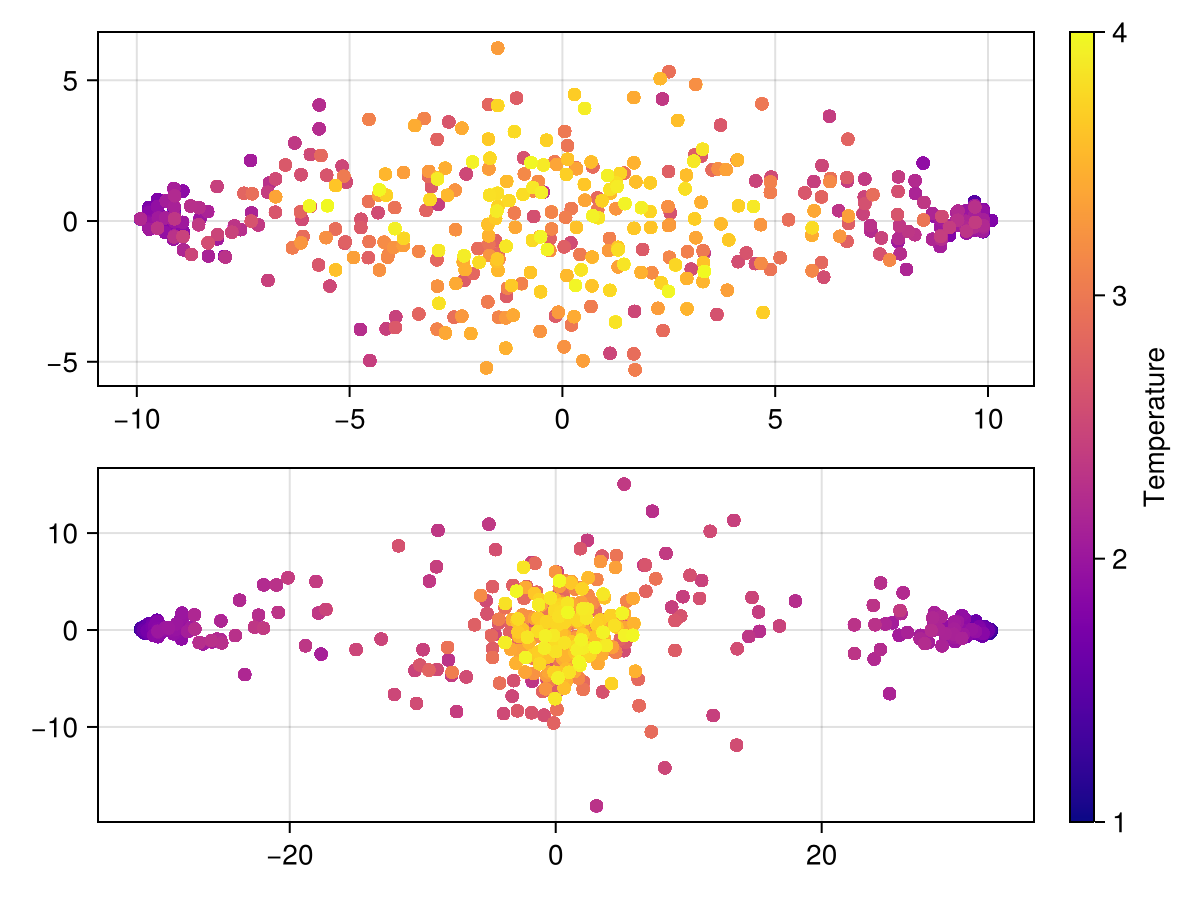

In [8]:
fig = cm.Figure()
cm.scatter(fig[1, 1], appl[1], color=expanded_temps, colormap=:plasma)
cm.scatter(fig[2, 1], appl[2], color=expanded_temps, colormap=:plasma)
# colorbar
cm.Colorbar(fig[:, 2], limits=(temps[begin], temps[end]), label="Temperature", colormap=:plasma)

fig

## K-means clustering


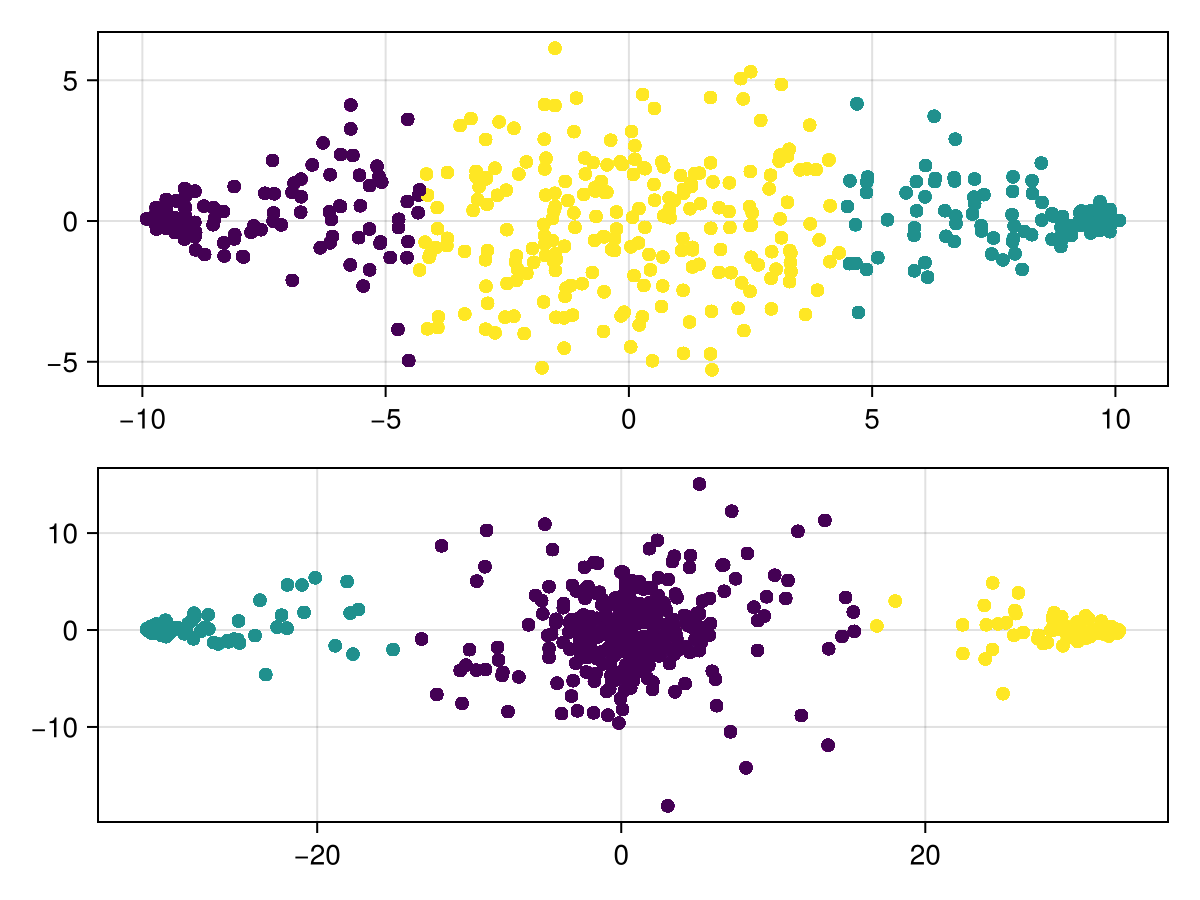

In [9]:
km1 = cl.kmeans(appl[1], 3)
km2 = cl.kmeans(appl[2], 3)

# plot clusters
fig = cm.Figure()
cm.scatter(fig[1, 1], appl[1], color=km1.assignments)
cm.scatter(fig[2, 1], appl[2], color=km2.assignments)
fig

In [11]:
a_mean = []
for i in 1:length(grid_sizes)
    am_ = []
    push!(am_, mean(reshape(abs.(appl[i][1,:]), (length(temps), N_Sample)), dims=2)[:])
    push!(am_, mean(reshape(abs.(appl[i][2,:]), (length(temps), N_Sample)), dims=2)[:])
    push!(a_mean, am_)
end

In [12]:
# normalize array to be from 0 to 1
normalize(x) = (x .- minimum(x)) ./ (maximum(x) .- minimum(x))

normalize (generic function with 1 method)

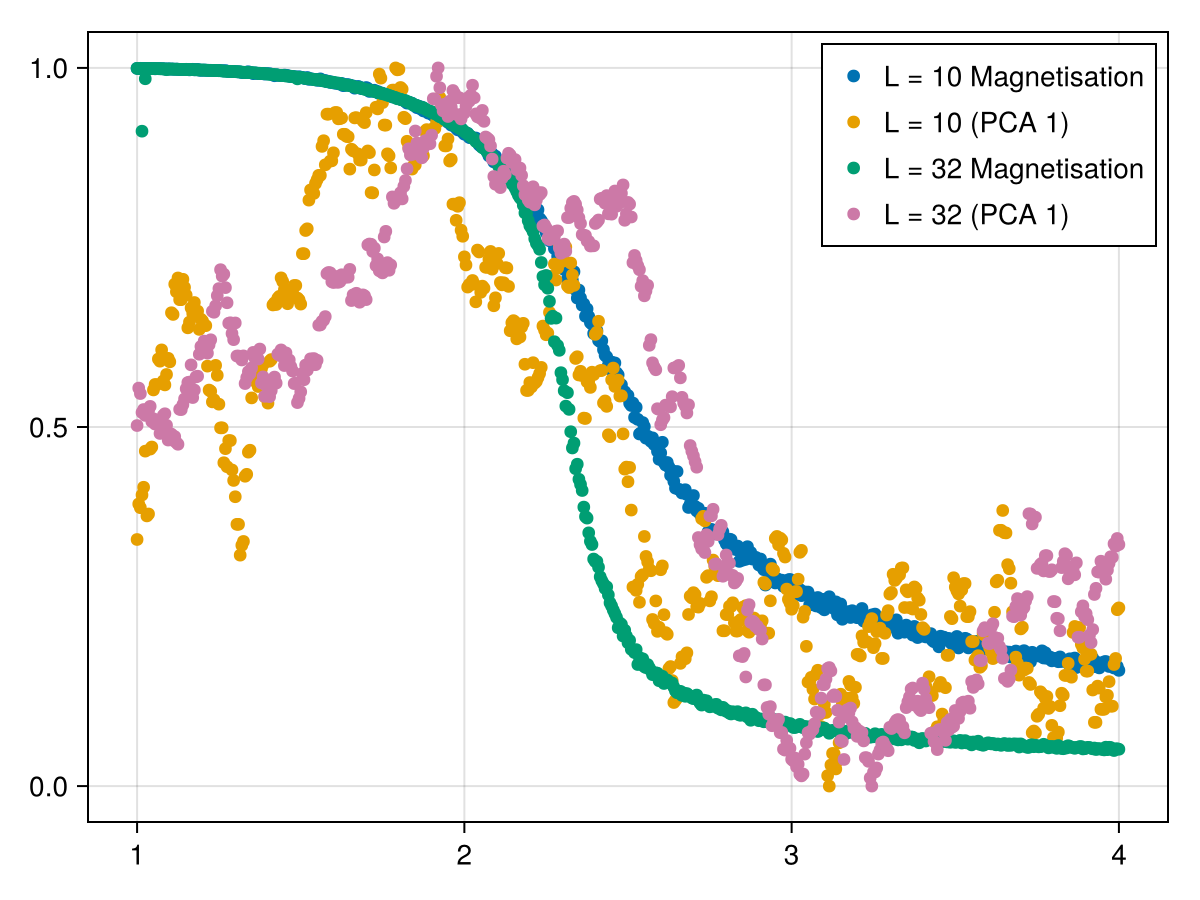

In [13]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1])
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, mags[i], label="L = $L Magnetisation")
    cm.plot!(ax, temps, normalize(a_mean[i][1]), label="L = $L (PCA 1)")
end
cm.axislegend(ax, position=:rt)
fig

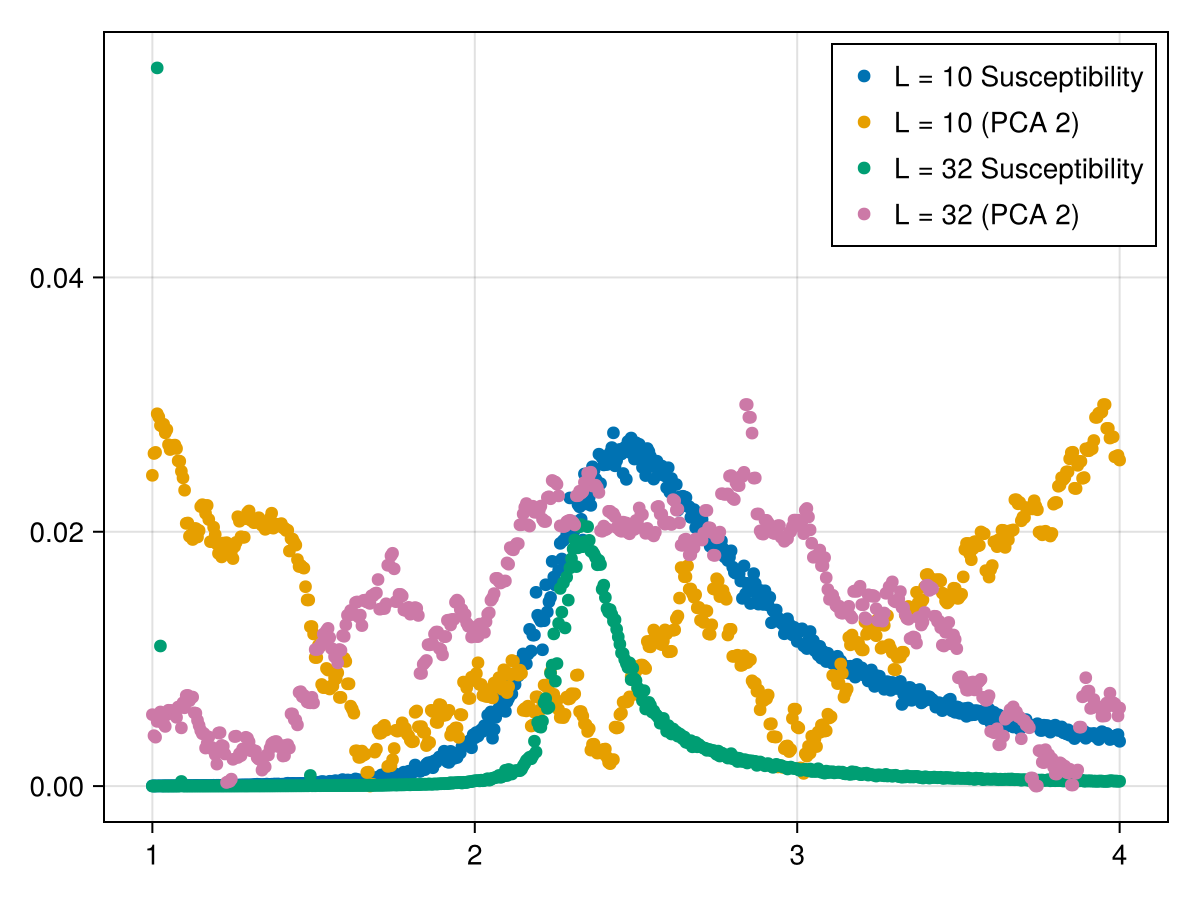

In [14]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1])
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, sus[i], label="L = $L Susceptibility")
    cm.plot!(ax, temps,normalize(a_mean[i][2]).*0.03, label="L = $L (PCA 2)")
end
cm.axislegend(ax, position=:rt)
fig